In [28]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings("ignore") 

In [3]:
data = pd.read_csv('rating_prediction_scrapped.csv')
print(data.shape)
data.head()

(20666, 2)


Ratings                    Reviews
0        5            Go For it....!!
1        5         Best For The Price
2        5        Amazing performance
3        5  Best RTX Laptop under 70k
4        5                 Impressive

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20666 entries, 0 to 20665
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Ratings  20666 non-null  int64 
 1   Reviews  20666 non-null  object
dtypes: int64(1), object(1)
memory usage: 323.0+ KB


In [5]:
data.Ratings.value_counts()

4    5000
5    4167
1    4080
2    4004
3    3415
Name: Ratings, dtype: int64

In [6]:
data.Reviews[90]

'Awesome'

In [7]:
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)

data.Reviews = data.Reviews.apply(clean)
data.Reviews[0]

'Go For it....!!'

In [8]:
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

data.Reviews = data.Reviews.apply(is_special)
data.Reviews[0]

'Go For it      '

In [9]:
def to_lower(text):
    return text.lower()

data.Reviews = data.Reviews.apply(to_lower)
data.Reviews[0]

'go for it      '

In [10]:
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

data.Reviews = data.Reviews.apply(rem_stopwords)
data.Reviews[0]

['go']

In [11]:
def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])

data.Reviews = data.Reviews.apply(stem_txt)
data.Reviews[0]

'go'

CREATING A MODEL

In [22]:
X = np.array(data.iloc[:,1].values)
y = np.array(data.Ratings.values)
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(data.Reviews).toarray()
print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

X.shape =  (20666, 1500)
y.shape =  (20666,)


In [23]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

CHOOSING THE BEST RANDOM STATE

In [29]:
max_acc=0
max_rs=0

for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=i) 
    m=MultinomialNB()
    m.fit(x_train,y_train)
    m.score(x_train,y_train)
    predm=m.predict(x_test)
    acc=accuracy_score(predm,y_test)   
       
    if acc>max_acc:
        max_acc=acc
        max_rs=i
print("best accuracy=",max_acc,"on random state",max_rs)

best accuracy= 0.4916129032258065 on random state 156


In [30]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=156)

In [31]:
model=[DecisionTreeClassifier(),MultinomialNB(),RandomForestClassifier()]
for i in model:
    i.fit(x_train,y_train)
    pred_test=i.predict(x_test)
    print("testing score=",accuracy_score(pred_test,y_test))         
    print("training score=",i.score(x_train,y_train))
    print(confusion_matrix(pred_test,y_test))
    print(classification_report(pred_test,y_test),"\n")

testing score= 0.5561290322580645
training score= 0.8432185815014517
[[794 247 121  62  53]
 [230 646 166 172 107]
 [ 66 131 420 157  78]
 [ 75 117 190 849 258]
 [ 69  70  80 303 739]]
              precision    recall  f1-score   support

           1       0.64      0.62      0.63      1277
           2       0.53      0.49      0.51      1321
           3       0.43      0.49      0.46       852
           4       0.55      0.57      0.56      1489
           5       0.60      0.59      0.59      1261

    accuracy                           0.56      6200
   macro avg       0.55      0.55      0.55      6200
weighted avg       0.56      0.56      0.56      6200
 

testing score= 0.4916129032258065
training score= 0.5369141435089174
[[774 303 151  70  70]
 [228 424 178 122  50]
 [ 76 189 270 157  41]
 [116 235 268 834 328]
 [ 40  60 110 360 746]]
              precision    recall  f1-score   support

           1       0.63      0.57      0.59      1368
           2       0.35      0

CROSS VALIDATION PROCESS

In [32]:
from sklearn.model_selection import cross_val_score
model=[DecisionTreeClassifier(),MultinomialNB(),RandomForestClassifier()]
for i in model:
    score=cross_val_score(i,X,y,cv=10) 
    print("score=",score)
    print("mean_score=",score.mean())
    print("std=",score.std(),"\n")

score= [0.47847121 0.6303822  0.61877117 0.60812772 0.59845186 0.492985
 0.57744434 0.56340755 0.51500484 0.48789932]
mean_score= 0.5570945213377039
std= 0.05549328784358575 

score= [0.43734881 0.48911466 0.47314949 0.46879536 0.42138365 0.42089985
 0.43659245 0.46369797 0.47967086 0.44724105]
mean_score= 0.4537894147229478
std= 0.023144458090379863 

score= [0.49250121 0.62554427 0.64199323 0.62941461 0.60570876 0.50556362
 0.5929332  0.57115198 0.53146176 0.50096805]
mean_score= 0.5697240694245206
std= 0.054780118852568296 



HYPERPARAMETER TUNING PROCESS FOR THE BEST MODEL

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
parameter={"bootstrap": [True,False],
          "criterion": ["gini","entropy"],
          "warm_start": [True,False],
          "max_features": ["auto","sqrt","log2"]}

In [35]:
gcv=GridSearchCV(RandomForestClassifier(),parameter,cv=10)

In [36]:
gcv.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'warm_start': [True, False]})

In [37]:
gcv.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 'log2',
 'warm_start': True}

In [38]:
final_model=RandomForestClassifier(criterion='gini',bootstrap=True,max_features='log2',warm_start=True)
final_model.fit(x_train,y_train)
pred=final_model.predict(x_test)
print(accuracy_score(pred,y_test))

0.5751612903225807


AUC-ROC CURVE

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [44]:
y_pred_prob=final_model.predict_proba(x_test)
y_pred_prob

array([[0.65128826, 0.04668503, 0.03368862, 0.24433316, 0.02400493],
       [0.00509876, 0.04349747, 0.01948259, 0.05613561, 0.87578557],
       [0.        , 0.03      , 0.8219881 , 0.1180119 , 0.03      ],
       ...,
       [0.04061604, 0.14783084, 0.18923199, 0.33472542, 0.28759571],
       [0.09225   , 0.07733333, 0.76216667, 0.06825   , 0.        ],
       [0.05252393, 0.07631225, 0.07220951, 0.50699955, 0.29195476]])

In [45]:
roc_auc_score(y_test,y_pred_prob, multi_class='ovo', average='weighted')

0.8365117473010637

Text(0.5, 1.0, 'RandomForestClassifier')

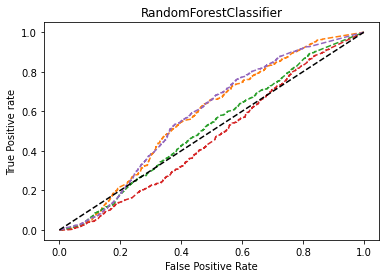

In [47]:
import matplotlib.pyplot as plt
fpr = {}
tpr = {}
thresh ={}

n_class =5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_prob[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i], linestyle='--')

plt.plot([0,1],[0,1],"k--")
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title("RandomForestClassifier")

SAVING THE BEST MODEL

In [49]:
import joblib

joblib.dump(final_model,"rating_prediction.obj")

['rating_prediction.obj']

In [50]:
rating_prediction_from_joblib=joblib.load("rating_prediction.obj")
rating_prediction_from_joblib.predict(x_test)

array([1, 5, 3, ..., 4, 3, 4], dtype=int64)